# Introduction

Kiva.org is a crowdfunding platform that seeks to provide loans to poor and financially excluded people around the world. Right now they are hand picking who gets the loans. What they want to be able to do is find some way to measure the level of poverty of a borrower so that they can better disperse their funds. For my solution I want to define regions as the country that the borrowers live in.

# Exploring the given datasets

In [315]:
import pandas as pd
import numpy as np
import pylab as pl
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot') # Have a nicer style of the plots

kiva_loans = pd.read_csv('kiva_loans.csv')
region_locations = pd.read_csv('kiva_mpi_region_locations.csv')
loan_theme_ids = pd.read_csv('loan_theme_ids.csv')
loan_themes_by_region = pd.read_csv('loan_themes_by_region.csv')

In [316]:
kiva_loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671205 entries, 0 to 671204
Data columns (total 20 columns):
id                    671205 non-null int64
funded_amount         671205 non-null float64
loan_amount           671205 non-null float64
activity              671205 non-null object
sector                671205 non-null object
use                   666977 non-null object
country_code          671197 non-null object
country               671205 non-null object
region                614405 non-null object
currency              671205 non-null object
partner_id            657698 non-null float64
posted_time           671205 non-null object
disbursed_time        668809 non-null object
funded_time           622874 non-null object
term_in_months        671205 non-null float64
lender_count          671205 non-null int64
tags                  499789 non-null object
borrower_genders      666984 non-null object
repayment_interval    671205 non-null object
date                  671205 non

In [317]:
region_locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 9 columns):
LocationName    984 non-null object
ISO             1008 non-null object
country         1008 non-null object
region          984 non-null object
world_region    1008 non-null object
MPI             984 non-null float64
geo             2772 non-null object
lat             892 non-null float64
lon             892 non-null float64
dtypes: float64(3), object(6)
memory usage: 195.0+ KB


In [318]:
loan_theme_ids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779092 entries, 0 to 779091
Data columns (total 4 columns):
id                 779092 non-null int64
Loan Theme ID      764279 non-null object
Loan Theme Type    764279 non-null object
Partner ID         764279 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 23.8+ MB


In [319]:
loan_themes_by_region.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15736 entries, 0 to 15735
Data columns (total 21 columns):
Partner ID            15736 non-null int64
Field Partner Name    15736 non-null object
sector                15736 non-null object
Loan Theme ID         15736 non-null object
Loan Theme Type       15736 non-null object
country               15736 non-null object
forkiva               15736 non-null object
region                15736 non-null object
geocode_old           1200 non-null object
ISO                   15722 non-null object
number                15736 non-null int64
amount                15736 non-null int64
LocationName          15736 non-null object
geocode               13662 non-null object
names                 13661 non-null object
geo                   15736 non-null object
lat                   13662 non-null float64
lon                   13662 non-null float64
mpi_region            15722 non-null object
mpi_geo               9671 non-null object
rural_pct     

Looking at the data the break down of columns we can see that the majority of the data regarding loans is held within the kiva_loans dataset. This is what I want to be looking at most closely. The other data sets serve as additional data related to these loans connected by id numbers. I think these could possibly be used for further informations. 

First, I want to take a look at the sector column of the kiva_loans dataset.

In [320]:
un = kiva_loans.sector.value_counts()
un

Agriculture       180302
Food              136657
Retail            124494
Services           45140
Personal Use       36385
Housing            33731
Clothing           32742
Education          31013
Transportation     15518
Arts               12060
Health              9223
Construction        6268
Manufacturing       6208
Entertainment        830
Wholesale            634
Name: sector, dtype: int64

This infomation seems to suggest that the people deciding which people are living in poverty and what the people in poverty need help with the most. This can serve as the basis for our metric in determining poverty levels of their borrowers. Another thing that we can also look at that could factor into poverty is housing. Another that we don't see in this data that we could also use is access to water. These are the basics for survival and it makes sense that places where there is not easy access to all three of these things would be areas of extreme poverty. 


In [321]:
kiva_loans.country.value_counts().median()

2313.0

# Gathering External Data

The column that I want to add to the kiva_loans data set is the GHI (Global Health Index). We want to see if there will be a correlation between the GHI and the loans

In [322]:
GHI = pd.read_csv('002_AppendixD.csv')

In [323]:
GHI.head()

,country,GHI
0,Afghanistan,33.3
1,Albania,11.1
2,Algeria,9.5
3,Angola,32.5
4,Argentina,5.4


Before merging the data sets lets drop some unneccessary features from the kiva loan data set

In [324]:
loans = kiva_loans[['country','loan_amount','activity','sector',
                    'borrower_genders', 'repayment_interval']]

In [325]:
d = pd.merge(loans,GHI, how='left')
d.count()

country               671205
loan_amount           671205
activity              671205
sector                671205
borrower_genders      666984
repayment_interval    671205
GHI                   630886
dtype: int64

In [326]:
incomplete_rows = d[d.isnull().any(axis=1)]
incomplete_rows.count()

country               44294
loan_amount           44294
activity              44294
sector                44294
borrower_genders      40073
repayment_interval    44294
GHI                    3975
dtype: int64

In [327]:
d = d.dropna(subset=['GHI'])
d = d.dropna(subset=['borrower_genders'])
incomplete_rows = d[d.isnull().any(axis=1)]
incomplete_rows.count()

country               0
loan_amount           0
activity              0
sector                0
borrower_genders      0
repayment_interval    0
GHI                   0
dtype: int64

In [328]:
d.loc[d.GHI == '<5', 'GHI'] = 5
d.GHI.unique()
d['GHI'] = d['GHI'].apply(pd.to_numeric, errors='coerce')

In [329]:
d = d.dropna(subset=['GHI'])
incomplete_rows = d[d.isnull().any(axis=1)]
incomplete_rows.count()

country               0
loan_amount           0
activity              0
sector                0
borrower_genders      0
repayment_interval    0
GHI                   0
dtype: int64

We only have GHI values for a subset of the countries so we got rid of a little bit of data with missing values. Now we are ready to explore the relationship between the GHI and the kiva loans data.

# Exploring the Relationship Between GHI and Kiva Loans

The first thing that we want to do is explore the relationship between the number of loans a country got and its GHI score.

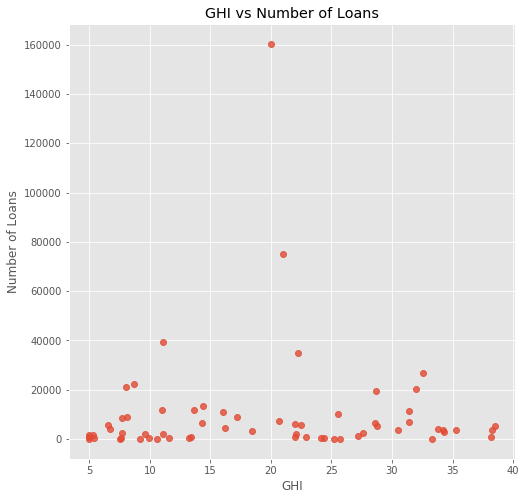

In [330]:
import seaborn as sns
d1 = d.groupby(['country','GHI'])['loan_amount'].count().reset_index(name='Number of Loans')
plt.figure(figsize=(8,8))
sns.regplot(x = d1.GHI, y = d1['Number of Loans'], fit_reg=False)
plt.title("GHI vs Number of Loans")
plt.show()

Now lets look and see if there is any relationship between GHI and total loan amounts for a country.

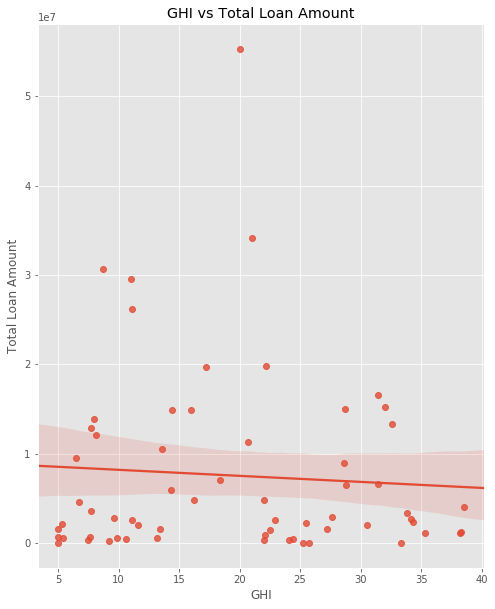

In [331]:
d2 = d.groupby(['country','GHI'])['loan_amount'].sum().reset_index(name='Total Loan Amount')
plt.figure(figsize=(8,10))
sns.regplot(x = d2.GHI, y = d2['Total Loan Amount'], fit_reg=True)
plt.title("GHI vs Total Loan Amount")
plt.show()

Now lets try mean loan amount by country

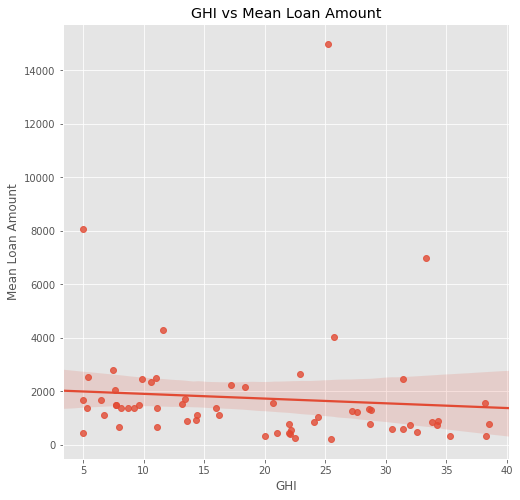

In [332]:
d3 = d.groupby(['country','GHI'])['loan_amount'].mean().reset_index(name='Mean Loan Amount')
plt.figure(figsize=(8,8))
sns.regplot(x = d3.GHI, y = d3['Mean Loan Amount'], fit_reg=True)
plt.title("GHI vs Mean Loan Amount")
plt.show()

It doesn't look like there is that much of a correlation between GHI and the loans. Lets try another approach.

# Trying MPI

In [333]:
loans2 = kiva_loans[['country', 'region', 'loan_amount','activity','sector',
                    'borrower_genders', 'repayment_interval']]

In [334]:
d = pd.merge(loans2, region_locations, how='left')
d.count()

country               671205
region                614405
loan_amount           671205
activity              671205
sector                671205
borrower_genders      666984
repayment_interval    671205
LocationName           50955
ISO                    52197
world_region           52197
MPI                    50955
geo                    52197
lat                    50953
lon                    50953
dtype: int64

In [335]:
d = d.dropna(subset=['MPI'])
d = d.dropna(subset=['lat'])
incomplete_rows = d[d.isnull().any(axis=1)]
incomplete_rows.count()

country               0
region                0
loan_amount           0
activity              0
sector                0
borrower_genders      0
repayment_interval    0
LocationName          0
ISO                   0
world_region          0
MPI                   0
geo                   0
lat                   0
lon                   0
dtype: int64

Now we have the Kiva loans data merged with the MPI data. Lets explore the relationships with MPI

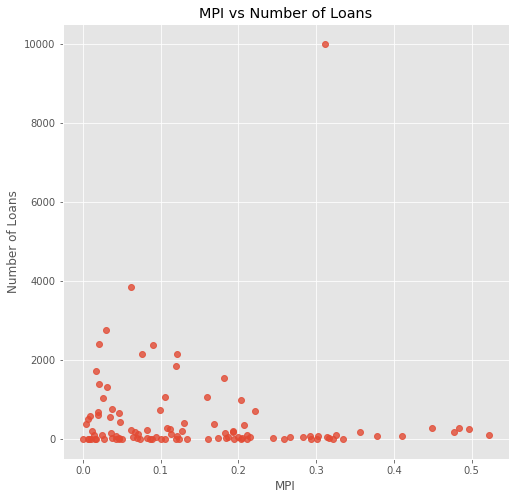

In [336]:
d1 = d.groupby(['country','MPI'])['loan_amount'].count().reset_index(name='Number of Loans')
plt.figure(figsize=(8,8))
sns.regplot(x = d1.MPI, y = d1['Number of Loans'], fit_reg=False)
plt.title("MPI vs Number of Loans")
plt.show()

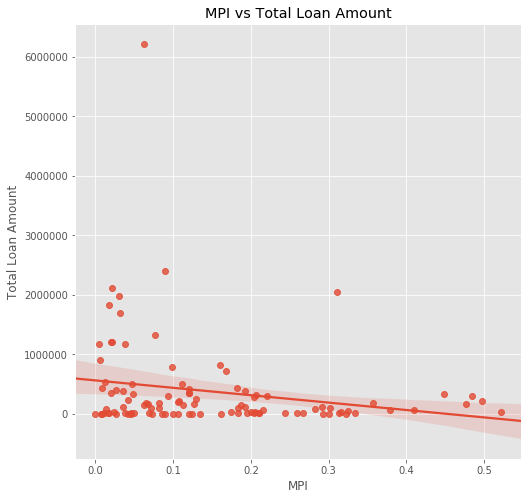

In [337]:
d2 = d.groupby(['country','MPI'])['loan_amount'].sum().reset_index(name='Total Loan Amount')
plt.figure(figsize=(8,8))
sns.regplot(x = d2.MPI, y = d2['Total Loan Amount'], fit_reg=True)
plt.title("MPI vs Total Loan Amount")
plt.show()

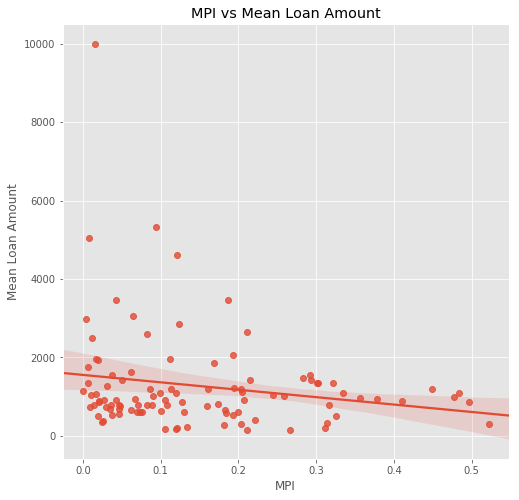

In [338]:
d3 = d.groupby(['country','MPI'])['loan_amount'].mean().reset_index(name='Mean Loan Amount')
plt.figure(figsize=(8,8))
sns.regplot(x = d3.MPI, y = d3['Mean Loan Amount'], fit_reg=True, order=0)
plt.title("MPI vs Mean Loan Amount")
plt.show()

Again we can see a bit of a corrleation between the MPI and statistics about the loans but nothing that is really strong enough to do any machine learning with. Lets try bringing in another data set.

# A Bunch of New Poverty Measures

In [288]:
country_stats = pd.read_csv('country_stats.csv')
country_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Data columns (total 13 columns):
country_name                     174 non-null object
country_code                     173 non-null object
country_code3                    173 non-null object
continent                        174 non-null object
region                           174 non-null object
population                       174 non-null int64
population_below_poverty_line    152 non-null float64
hdi                              171 non-null float64
life_expectancy                  168 non-null float64
expected_years_of_schooling      168 non-null float64
mean_years_of_schooling          168 non-null float64
gni                              168 non-null float64
kiva_country_name                174 non-null object
dtypes: float64(6), int64(1), object(6)
memory usage: 17.8+ KB


In [289]:
country_stats = country_stats.rename(columns={'kiva_country_name': 'country'})
country_stats = country_stats[['country','region','population','population_below_poverty_line',
                              'hdi','life_expectancy','expected_years_of_schooling',
                               'mean_years_of_schooling','gni']]
country_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Data columns (total 9 columns):
country                          174 non-null object
region                           174 non-null object
population                       174 non-null int64
population_below_poverty_line    152 non-null float64
hdi                              171 non-null float64
life_expectancy                  168 non-null float64
expected_years_of_schooling      168 non-null float64
mean_years_of_schooling          168 non-null float64
gni                              168 non-null float64
dtypes: float64(6), int64(1), object(2)
memory usage: 12.3+ KB


In [290]:
d = pd.merge(loans, country_stats, how='left')
d.count()

country                          671205
loan_amount                      671205
activity                         671205
sector                           671205
borrower_genders                 666984
repayment_interval               671205
region                           671182
population                       671182
population_below_poverty_line    654922
hdi                              671039
life_expectancy                  654057
expected_years_of_schooling      654057
mean_years_of_schooling          654057
gni                              654057
dtype: int64

In [291]:
just_loan_and_country = d[['country','loan_amount']]

In [292]:
number_of_loans = just_loan_and_country.groupby(['country'])['loan_amount'].count().reset_index(name='number_of_loans')
number_of_loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 2 columns):
country            87 non-null object
number_of_loans    87 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [293]:
total_loan_amount = just_loan_and_country.groupby(['country'])['loan_amount'].sum().reset_index(name='total_loan_amount')
total_loan_amount.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 2 columns):
country              87 non-null object
total_loan_amount    87 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.4+ KB


In [294]:
d = d[['country','population','population_below_poverty_line',
                              'hdi','life_expectancy','expected_years_of_schooling',
                               'mean_years_of_schooling','gni']]
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 671205 entries, 0 to 671204
Data columns (total 8 columns):
country                          671205 non-null object
population                       671182 non-null float64
population_below_poverty_line    654922 non-null float64
hdi                              671039 non-null float64
life_expectancy                  654057 non-null float64
expected_years_of_schooling      654057 non-null float64
mean_years_of_schooling          654057 non-null float64
gni                              654057 non-null float64
dtypes: float64(7), object(1)
memory usage: 46.1+ MB


In [295]:
loan_info = pd.merge(total_loan_amount,number_of_loans, how='left')
d = pd.merge(d, loan_info, how='left')

In [296]:
d = d.dropna(axis=0, how='any')
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 653503 entries, 0 to 671204
Data columns (total 10 columns):
country                          653503 non-null object
population                       653503 non-null float64
population_below_poverty_line    653503 non-null float64
hdi                              653503 non-null float64
life_expectancy                  653503 non-null float64
expected_years_of_schooling      653503 non-null float64
mean_years_of_schooling          653503 non-null float64
gni                              653503 non-null float64
total_loan_amount                653503 non-null float64
number_of_loans                  653503 non-null int64
dtypes: float64(8), int64(1), object(1)
memory usage: 54.8+ MB


In [297]:
d['mean_loan_amount'] = d['total_loan_amount']/d['number_of_loans']

In [298]:
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 653503 entries, 0 to 671204
Data columns (total 11 columns):
country                          653503 non-null object
population                       653503 non-null float64
population_below_poverty_line    653503 non-null float64
hdi                              653503 non-null float64
life_expectancy                  653503 non-null float64
expected_years_of_schooling      653503 non-null float64
mean_years_of_schooling          653503 non-null float64
gni                              653503 non-null float64
total_loan_amount                653503 non-null float64
number_of_loans                  653503 non-null int64
mean_loan_amount                 653503 non-null float64
dtypes: float64(9), int64(1), object(1)
memory usage: 59.8+ MB


In [299]:
corr_mat = d.corr()
corr_mat

,population,population_below_poverty_line,hdi,life_expectancy,expected_years_of_schooling,mean_years_of_schooling,gni,total_loan_amount,number_of_loans,mean_loan_amount
population,1.000000,-0.150172,0.051417,-0.023801,-0.034618,0.019325,0.129590,-0.021841,0.030219,-0.049455
population_below_poverty_line,-0.150172,1.000000,-0.535735,-0.522166,-0.318695,-0.439826,-0.342654,-0.351682,-0.304330,-0.010367
hdi,0.051417,-0.535735,1.000000,0.847618,0.839387,0.813857,0.763552,0.338258,0.232859,0.241745
life_expectancy,-0.023801,-0.522166,0.847618,1.000000,0.717923,0.516485,0.573171,0.046894,-0.072171,0.321454
expected_years_of_schooling,-0.034618,-0.318695,0.839387,0.717923,1.000000,0.623784,0.651332,0.138755,0.004929,0.330415
mean_years_of_schooling,0.019325,-0.439826,0.813857,0.516485,0.623784,1.000000,0.570821,0.491430,0.437597,0.120854
gni,0.129590,-0.342654,0.763552,0.573171,0.651332,0.570821,1.000000,0.182967,0.074298,0.497922
total_loan_amount,-0.021841,-0.351682,0.338258,0.046894,0.138755,0.491430,0.182967,1.000000,0.954174,-0.339516
number_of_loans,0.030219,-0.304330,0.232859,-0.072171,0.004929,0.437597,0.074298,0.954174,1.000000,-0.497136
mean_loan_amount,-0.049455,-0.010367,0.241745,0.321454,0.330415,0.120854,0.497922,-0.339516,-0.497136,1.000000


Now we have some data that we could do some machine learning with. We have got rid of a lot of the extraneous data and now we are down to just the countries, several measures of poverty, and some loan data. Lets look at the total loan amount. I think this is a good indicator of how poor a country is and how in need of loans that they are. If the total loan amount is above the mean for this data, we can say that these countries are most in need. Lets add a column for this class and see if we can create a classfier with the measures of poverty

# Prepping Data for ML

In [300]:
d['in_need'] = np.where(d['total_loan_amount']>d['total_loan_amount'].mean(), 1, 0)

In [301]:
d = d[['population_below_poverty_line',
                              'hdi','life_expectancy','expected_years_of_schooling',
                               'mean_years_of_schooling','gni','in_need']]
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 653503 entries, 0 to 671204
Data columns (total 7 columns):
population_below_poverty_line    653503 non-null float64
hdi                              653503 non-null float64
life_expectancy                  653503 non-null float64
expected_years_of_schooling      653503 non-null float64
mean_years_of_schooling          653503 non-null float64
gni                              653503 non-null float64
in_need                          653503 non-null int32
dtypes: float64(6), int32(1)
memory usage: 37.4 MB


In [302]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(d)

x_train = train_set.drop(['in_need'], axis=1)
y_train = train_set['in_need']
x_test = test_set.drop(['in_need'], axis=1)
y_test = test_set['in_need']

In [303]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=2)
clf.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [304]:
from sklearn.model_selection import cross_val_score
cross_val_score(clf, x_test, y_test, cv=3, scoring="accuracy")

array([ 0.87275064,  0.87245216,  0.87065261])

In [305]:
from sklearn.model_selection import cross_val_predict

y_test_pred = cross_val_predict(clf, x_test, y_test, cv=3)

In [306]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_test_pred)

array([[78087, 16435],
       [ 4485, 64369]], dtype=int64)

In [307]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_test, y_test_pred)

0.79660660363348346

In [308]:
from sklearn.metrics import precision_score, recall_score

recall_score(y_test, y_test_pred)

0.93486217213233802

In [309]:
from sklearn.metrics import f1_score
f1_score(y_test, y_test_pred)

0.86021462267302784

In [313]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

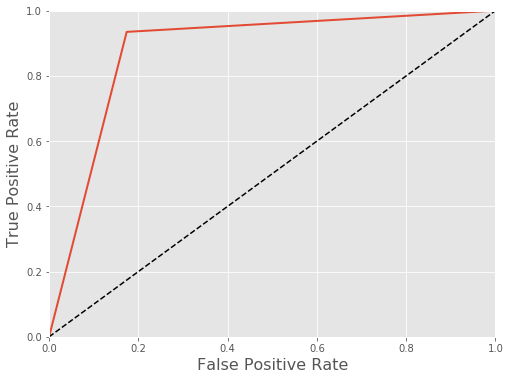

In [314]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

# Conclusion

Kiva is looking for a way to determine poverty to determine who needs their loans the most. If we were to take into consideration poverty measures such as population below poverty line, hdi, life expectancy, schooling, and gni, we can start to build a bigger picture of which countries are actually in need of Kiva loans. If we classify the countries with a total loan amount greater than the mean total loan amount as countries in need we can use a classifier to determine whether a particular loan should be approved or not.

Using the poverty measures I have just mentioned in conjunction with the country of the borrower, my decision tree model does a pretty good job of predicting whether or not a particular borrower is in a country that is in need of Kiva loans.

# Files Used

GHI dataset from: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/ZTCWYQ
country_stats dataset from: https://www.kaggle.com/gaborfodor/external-data-for-kiva-crowdfunding/data
rest of the data is from the Kiva datasets